In [6]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
import porepy as pp

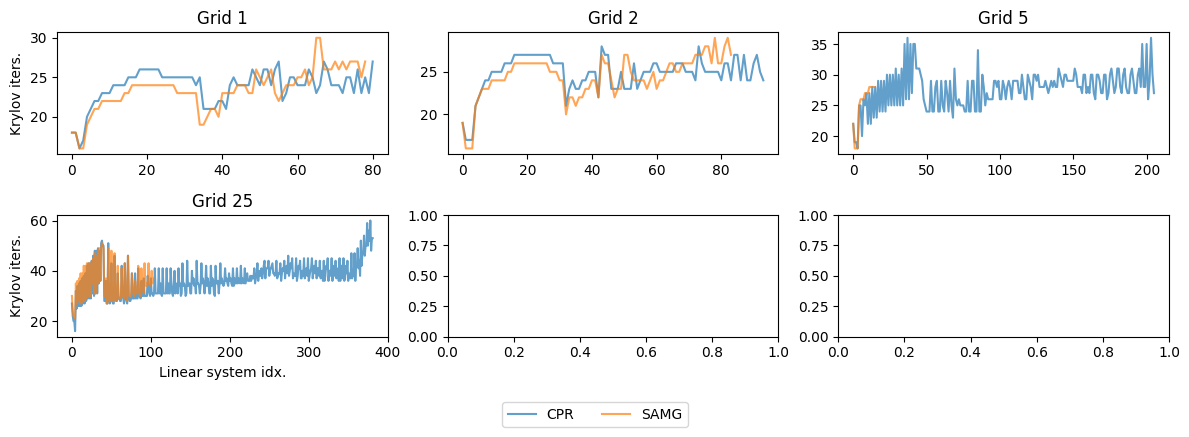

In [178]:
grids = [
    1,
    2,
    5,
    25,
    # 33,
    # 40,
]

solvers = [
    "CPR",
    "SAMG",
    # "S4_diag",
    # "SAMG+ILU",
    # "S4_diag+ILU",
    # "AAMG+ILU",
]
colors = {name: f"C{i}" for i, name in enumerate(solvers)}

data = {}
names = {}
for i, g in enumerate(grids):
    data[i] = {}
    names[i] = f"Grid {g}"
    for s in solvers:
        try:
            data[i][s] = load_data(
                f"../stats/stats_thermal_geo4h_steadyx{g}_sol{s}.json"
            )
        except:
            continue


shape = [2, 3]
figsize = (12, 4)
DAY = 3600 * 24


def render_element(i, data):
    if len(data) == 0:
        return
    for solver_name, d in data.items():
        # color_converged_reason(d, legend=True)
        plt.plot(get_gmres_iterations(d), label=solver_name, alpha=0.7, c=colors[solver_name])
        # plt.plot(get_newton_iterations(d), label=solver_name, alpha=0.7, c=colors[solver_name])

        # plt.plot(np.cumsum(get_time_steps(d)), alpha=0.7, label=solver_name)
        # plt.yscale('log')
        # plt.plot(get_newton_iterations(d), alpha=0.7, label=solver_name)

    # plt.twinx()
    # plt.plot(np.cumsum(get_time_steps(data['SAMG'])) / DAY , alpha=0.7, label=solver_name)
    # plt.gca().grid(True)
    # # set_integer_ticks("vertical")
    # color_converged_reason(data['SAMG'], legend=True)
    # color_time_steps(data['CPR'], fill=True, legend=True)
    # plt.yscale('log')


plot_grid(
    data, render_element, shape=shape, figsize=figsize, legend=True, ax_titles=names
)

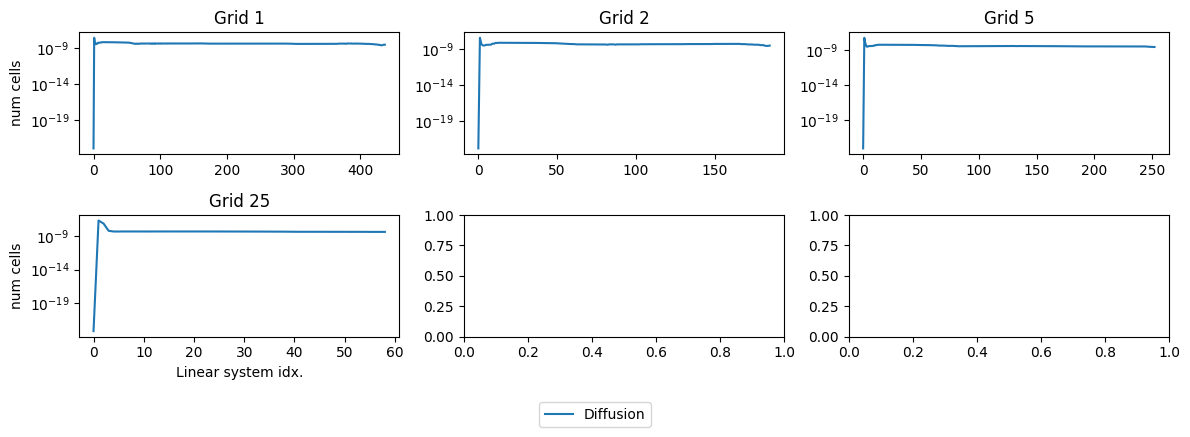

In [86]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    entry = entry.get('SAMG')
    if entry is None:
        return
    
    enthalpy = get_enthalpy_max(entry)
    fourier = get_fourier_max(entry)
    # plt.plot(enthalpy, label='Convection')
    # plt.ylim(bottom=1e-4)
    plt.plot(fourier, label='Diffusion')
    # plt.ylim(bottom=1e-9)
    plt.yscale('log')

    # st, sl, op = get_num_sticking_sliding_open(entry)
    # color_time_steps(entry, fill=True, grid=False, legend=True)
    # plt.gca().grid(False)
    # plt.gca().grid(True, which="major", axis="y")
    # marker = None
    # plt.plot(st, label="Sticking", marker=marker, color=COLOR_STICKING)
    # plt.plot(sl, label="Sliding", marker=marker, color=COLOR_SLIDING)
    # plt.plot(op, label="Open", marker=marker, color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)

    # cfl = get_cfl(entry)
    # peclet_max = get_peclet_max(entry)
    # peclet_mean = get_peclet_mean(entry)
    # plt.twinx()
    # plt.plot(cfl, label='CFL')
    # plt.plot(peclet_mean, label=r'$P_{max}$')
    # plt.yscale('log')

plot_grid(
    data,
    render_element,
    shape=shape,
    figsize=figsize,
    ylabel="num cells",
    ax_titles=names,
    #   ylabel="Fract. len., m"
)
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

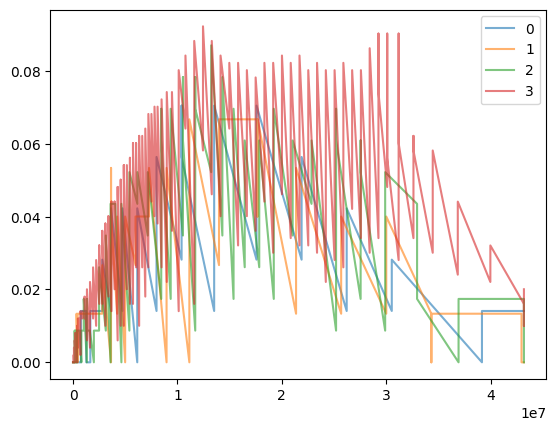

In [176]:
def render_element(i: int, entry: Sequence[TimeStepStats]):
    entry = entry.get("CPR")
    if entry is None:
        return
    # color_time_steps(entry, fill=True, grid=False, legend=True)
    cfl = get_cfl(entry)
    enthalpy = get_enthalpy_max(entry)
    ts = np.cumsum(get_time_steps(entry))
    ls = get_ls_indices(entry)
    fourier = get_fourier_max(entry)
    # plt.plot(enthalpy, label='Convection')
    # plt.plot(ts[ls], fourier, label=i)
    # plt.yscale("log")

    # peclet = get_peclet_max(entry)
    # peclet = get_peclet_mean(entry)
    # plt.plot(peclet, label=r'$Pe$')
    # plt.plot(cfl, label='CFL')
    # plt.twinx()
    # plt.plot(peclet_max, label=r'$P_{max}$')
    # plt.yscale('log')
    # plt.ylim(bottom=1e-2)
    # plt.twinx()
    # DAY = 3600 * 24
    # plt.plot(np.cumsum(get_time_steps(entry)) / DAY , color='black', alpha=0.5, label='Time')
    # plt.yscale('log')
    st, sl, op = get_num_sticking_sliding_open(entry)
    # plt.gca().grid(False)
    # plt.gca().grid(True, which="major", axis="y")
    marker = None
    # plt.plot(st, label="Sticking", marker=marker, color=COLOR_STICKING)
    plt.plot(ts[ls], sl / (st+sl+op), label=i, marker=marker, alpha=0.6)
    # plt.plot(op, label="Open", marker=marker, color=COLOR_OPEN)
    # plt.plot(tr, label="Transition", marker=".", color=COLOR_TRANSITION)

for i, d in data.items():
    render_element(i, d)

# plt.ylim(bottom=2e-9, top=1e-8)
plt.legend()


# plot_grid(
#     data,
#     render_element,
#     shape=shape,
#     figsize=figsize,
#     ylabel="num cells",
#     ax_titles=names,
#     #   ylabel="Fract. len., m"
# )
# plt.savefig(save_path + 'fracture_length.pdf', bbox_inches='tight')

In [89]:
from collections import defaultdict
import pandas as pd

table = dict()

NDIGITS = 3

for g in grids:
    table[g] = {}
    for s in solvers:
        stats_name = f"stats_thermal_geo4h_steadyx{g}_sol{s}.json"
        try:
            entry = load_data(f"../stats/{stats_name}")
            dofs_info = load_data(f"../stats/dofs_info_{stats_name}")
        except FileNotFoundError:
            continue
        total_dofs = dofs_info["total dofs"]
        table[g]["Total DoFs"] = str(int(total_dofs))
        table[g][s] = round(np.mean(get_gmres_iterations(entry)), NDIGITS)
        # table[g][s] = (np.sum(get_gmres_iterations(entry)))

        # if g in [1, 2, 5]:
        #     direct = load_data(f"../stats/stats_geo0x{g}_sol{21}_ph{1}_bb{2}_fr{1}.json")
        #     table["GMRES dir."].append(round(np.mean(get_gmres_iterations(direct)), NDIGITS))
        # else:
        #     table["GMRES dir."].append('-')

        # table['Newton iters.'].append(round(np.mean(get_newton_iterations(entry)), NDIGITS))
        # converged_reason = get_petsc_converged_reason(entry)
        # table['\# lim iters.'].append(sum(np.array(get_petsc_converged_reason(entry)) < 0))

table = pd.DataFrame(table)
table.rename(columns=table.loc['Total DoFs'], inplace=True)
table.drop('Total DoFs', axis=0, inplace=True)
table.columns.name = 'Total DoFs'
table

Total DoFs,5240,8992,30752,608048
CPR,22.245,24.536,27.689,37.055
SAMG,21.121,23.597,28.542,34.731


In [5]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from plot_utils import *
from thermal_runscript_1 import make_model
import porepy as pp

model = make_model(
    {
        "physics": 1,
        "geometry": 0,
        "barton_bandis_stiffness_type": 2,
        "friction_type": 1,
        "grid_refinement": 1,
        "solver": 1,
        "save_matrix": False,
        "high_boundary_pressure_ratio": 13,
        'steady_state': False,
        'initial_state': 'ignore',
    }
)
model.prepare_simulation()
model.before_nonlinear_loop()
model.before_nonlinear_iteration()
model.assemble_linear_system()
rhs = model.linear_system[1]



Sim time: 0.00e+00, Dt: 5.00e-01 (days)
Temperature: 350.00, 350.00
Peclet: 4.5e+03, CFL: 5.3e-03
sticking: 6, sliding: 0, open: 0


In [6]:
mat, rhs, state, iterate, dt = load_matrix_rhs_state_iterate_dt(
    load_data(f"../stats/{model.simulation_name()}.json"), 9
)

FileNotFoundError: [Errno 2] No such file or directory: '../stats/stats_thermal_geo0x1_sol1.json'

In [ ]:
model.linear_system = mat, rhs
model.bmat.mat = mat
model.equation_system.set_variable_values(state, time_step_index=0)
model.equation_system.set_variable_values(iterate, iterate_index=0)
model.ad_time_step.set_value(dt)
model.time_manager.dt = dt

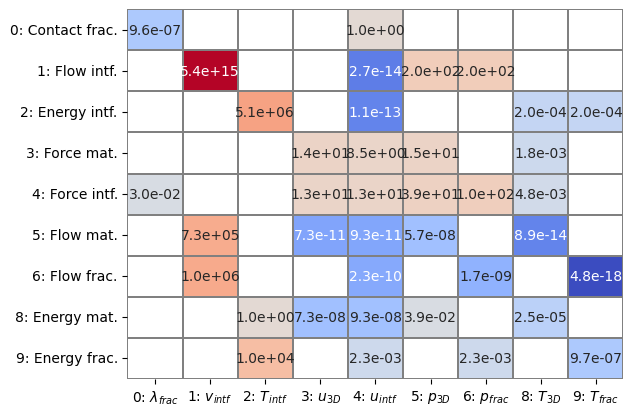

In [7]:
J = model.bmat[:]
J.plot_max()

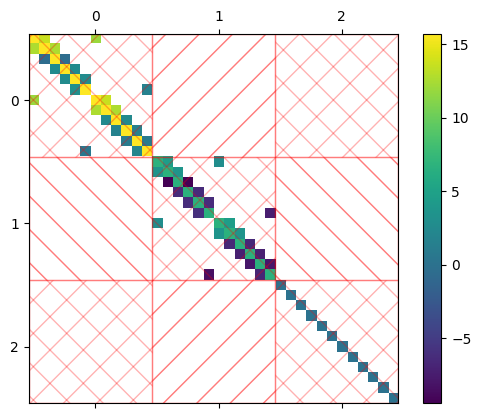

In [9]:
J[[1,2]].matshow_blocks(groups=False)

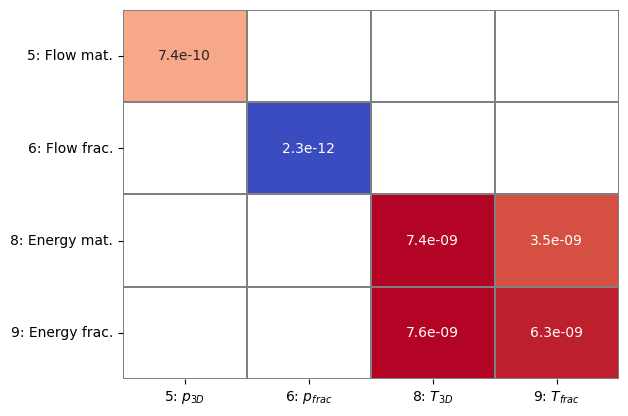

In [107]:
from fixed_stress import make_fs_analytical
from mat_utils import *
from block_matrix import *


def make_stab(bmat: BlockMatrixStorage, keep: list[int], elim: list[int]):
    stab = bmat[keep].empty_container()
    stab.mat += bmat[keep, elim].mat @ inv(bmat[elim].mat) @ bmat[elim, keep].mat
    return stab


def make_S(bmat: BlockMatrixStorage, keep: list[int], elim: list[int]):
    stab = make_stab(bmat, keep, elim)
    S = bmat[keep]
    S.mat -= stab.mat

elim = [0, 1, 2, 3, 4]
keep = [5, 6, 8, 9]
stab1 = make_stab(J, elim=elim, keep=keep)
# stab1.set_zeros([5,6], [5,6])
stab1.set_zeros([5,6], [8,9])
stab1.set_zeros([8,9], [5,6])
# stab1.set_zeros([8,9], [8,9])
fs = make_fs_analytical(model, J, 5, 6)
stab1[[5,6]] = fs.mat
stab1.plot_max()

Construction took: 0.39
Solve  took: 0.01
True residual: 7.94028274806183e-09
PETSc Converged Reason: 2


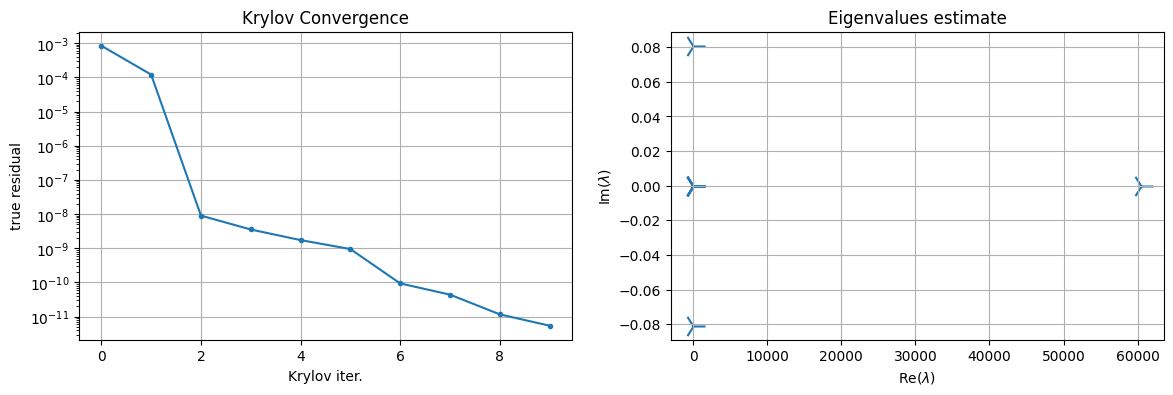

In [106]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        preconditioner=FieldSplitScheme(
            groups=[0, 1, 2, 3, 4],
            invertor_type='physical',
            invertor=lambda bmat: -stab1.mat,
            complement=FieldSplitScheme(
                groups=[5, 6, 8, 9]
            ),
        ),
    ),
)

all: 11
none: 16
only_mat: 11
only_frac: 16

Construction took: 0.66
Solve  took: 0.0
True residual: 9.59876304735366e-12
PETSc Converged Reason: 2


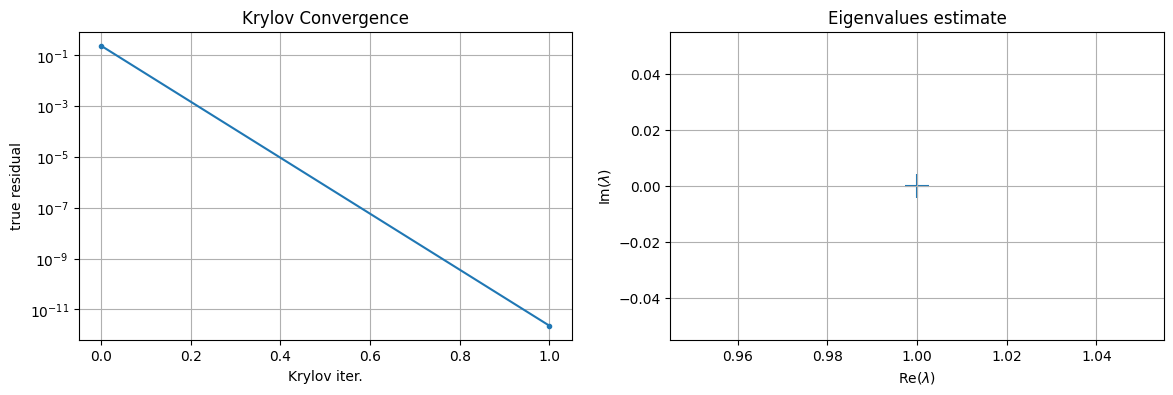

In [36]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        # ksp="richardson",
        rtol=1e-8,
        preconditioner=FieldSplitScheme(
            groups=[1],
            complement=FieldSplitScheme(
                groups=[0, 2, 3],
                invertor=lambda bmat: make_fs_analytical(
                    model, bmat, p_mat_group=4, p_frac_group=5
                ).mat
                * 1,
                invertor_type="physical",
                complement=FieldSplitScheme(
                    groups=[4, 5],
                ),
            ),
        ),
    ),
)

Solve  took: 0.47
True residual: 1.2595284410140698e-14
PETSc Converged Reason: 2


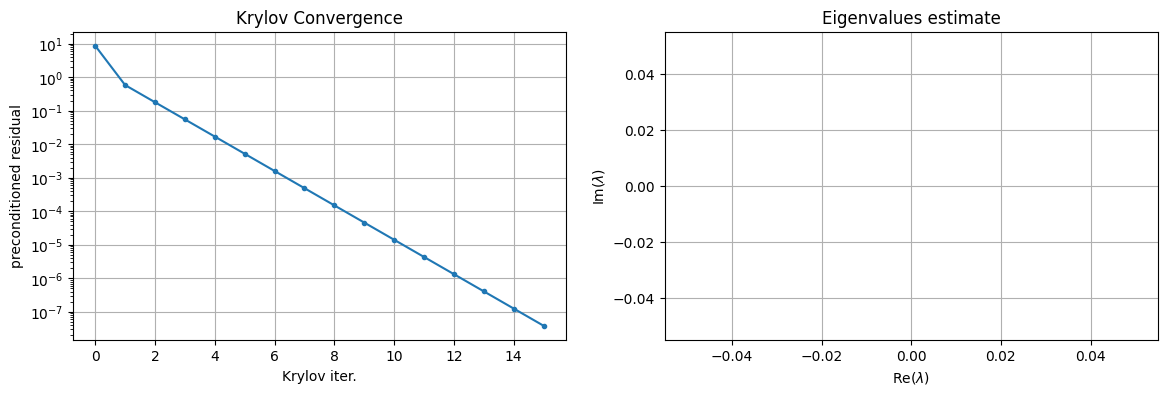

In [14]:
from fixed_stress import make_fs_analytical
from hm_solver import build_mechanics_near_null_space
from mat_utils import *
from block_matrix import *

solve_petsc_3(
    J,
    rhs_global=rhs,
    ksp_scheme=KSPScheme(
        ksp="richardson",
        rtol=1e-8,
        right_transformations=[
            lambda bmat: model.Qright(contact_group=0, u_intf_group=3)
        ],
        preconditioner=FieldSplitScheme(
            # Exactly solve elasticity and contact mechanics, build fixed stress.
            groups=[1],
            complement=FieldSplitScheme(
                groups=[0, 2, 3],
                invertor=lambda bmat: make_fs_analytical(
                    model, bmat, p_mat_group=4, p_frac_group=5
                ).mat * 0,
                invertor_type="physical",
                complement=FieldSplitScheme(
                    groups=[4, 5],
                ),
            ),
        ),
    ),
)